In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# 데이터 불러오기

In [38]:
train = pd.read_csv('./data/train (1).csv')
test = pd.read_csv('./data/test (1).csv')

## features

In [39]:
common_cols = [
    'type', 'runtime', 'season_count', 'episode_count',
    'genre', 'director', 'cast', 'country', 'language',
    'production_company', 'tags',
    'imdb_rating', 'imdb_review_count',
    'production_company_is_missing', 'director_is_missing', 'cast_is_missing',
    'cast_award_score', 'director_top_score', 'actor_top_score', 'director_productivity_success'
]

X = train[common_cols].copy()
y = train['success_label']
X_test_final = test[common_cols].copy()

## 범주형 변수 label_encoding

In [40]:
cat_features = [
    'type', 'genre', 'director', 'cast', 'country',
    'language', 'production_company', 'tags'
]

for col in cat_features:
    le = LabelEncoder()
    combined = pd.concat([X[col], X_test_final[col]], axis=0).astype(str)
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))

## 데이터 분리

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=26, stratify=y
)

## xGboost 모델 학습

In [42]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_valid_pred = xgb_model.predict(X_valid)
y_valid_prob_xgb = xgb_model.predict_proba(X_valid)[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 성능평가

In [43]:
acc = accuracy_score(y_valid, y_valid_pred)
prec = precision_score(y_valid, y_valid_pred)
rec = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)
roc = roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")

Accuracy: 0.9921
Precision: 0.9984
Recall: 0.9633
F1 Score: 0.9805
ROC-AUC: 0.9860


## feature 중요도 시각화

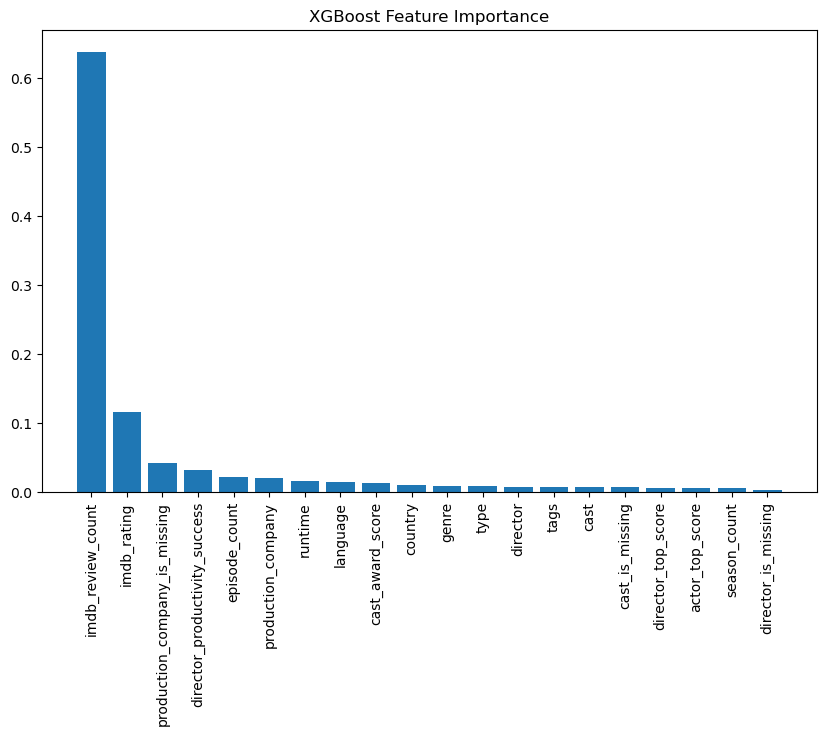

In [44]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = [common_cols[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features_sorted, rotation=90)
plt.show()

## 하이퍼파라미터 튜닝

In [45]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_grid = xgb.XGBClassifier(
    random_state=42,
    tree_method="hist",
    use_label_encoder=False,
    eval_metric='logloss'
)

grid_search = GridSearchCV(estimator=xgb_grid, param_grid=param_grid,
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score from GridSearchCV: ", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}
Best F1 score from GridSearchCV:  0.9824548739033453


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:35:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 최적화된 파라미터

In [46]:
best_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42,
    tree_method="hist",
    use_label_encoder=False,
    eval_metric='logloss'
)
best_model.fit(X, y)

# test 예측 수행
final_test_preds = best_model.predict(X_test_final)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:35:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## LightGBM 모델학습

In [47]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_valid_pred = lgb_model.predict(X_valid)
y_valid_prob_lgb = lgb_model.predict_proba(X_valid)[:, 1]
## 이미 충분히 분할이 되어서 이 피처에서는 더 이상 유의미한 분할을 찾지 못함

[LightGBM] [Info] Number of positive: 10455, number of negative: 40167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3096
[LightGBM] [Info] Number of data points in the train set: 50622, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206531 -> initscore=-1.345965
[LightGBM] [Info] Start training from score -1.345965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## 성능평가

In [48]:
acc = accuracy_score(y_valid, y_valid_pred)
prec = precision_score(y_valid, y_valid_pred)
rec = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)
roc = roc_auc_score(y_valid, lgb_model.predict_proba(X_valid)[:, 1])

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")

Accuracy: 0.9921
Precision: 0.9984
Recall: 0.9633
F1 Score: 0.9805
ROC-AUC: 0.9851


## feature 중요도 시각화

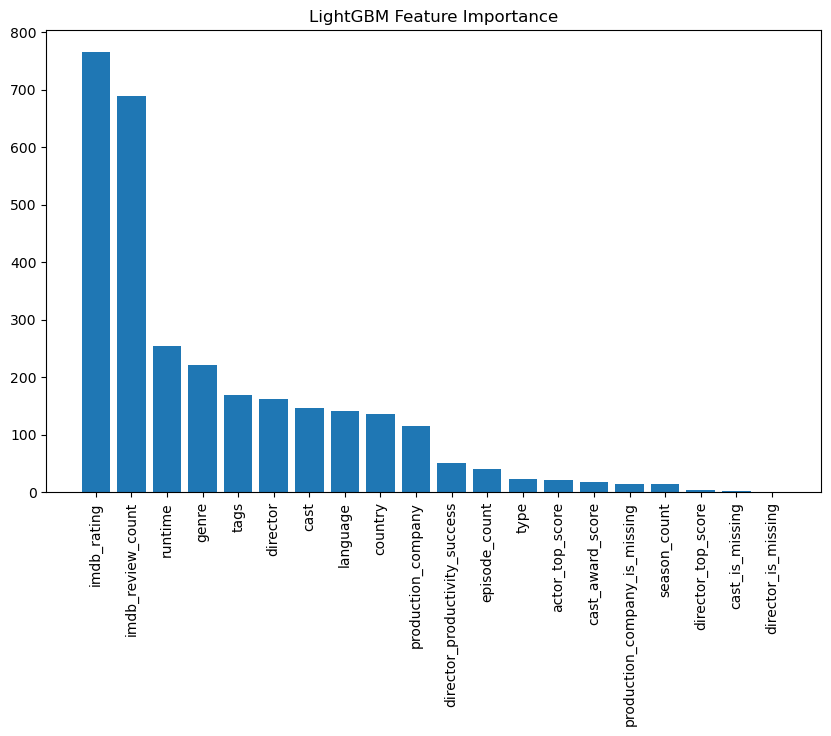

In [49]:
importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = [common_cols[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("LightGBM Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features_sorted, rotation=90)
plt.show()


## 하이퍼파라미터 튜닝

In [50]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score from GridSearchCV: ", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Info] Number of positive: 6970, number of negative: 26778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 33748, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206531 -> initscore=-1.345965
[LightGBM] [Info] Start training from score -1.345965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

## 최종학습

In [51]:
best_model = lgb.LGBMClassifier(
    **grid_search.best_params_,
    random_state=42
)
best_model.fit(X, y)

final_test_preds = best_model.predict(X_test_final)

[LightGBM] [Info] Number of positive: 13069, number of negative: 50209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 63278, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206533 -> initscore=-1.345951
[LightGBM] [Info] Start training from score -1.345951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## 성능비교

In [52]:
def evaluate_model(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    return acc, prec, rec, f1, roc

In [54]:
xgb_scores = evaluate_model(y_valid, y_valid_pred, y_valid_prob_xgb)
lgb_scores = evaluate_model(y_valid, y_valid_pred, y_valid_prob_lgb)

print("XGBoost 성능:")
print(f"Accuracy: {xgb_scores[0]:.4f}, Precision: {xgb_scores[1]:.4f}, Recall: {xgb_scores[2]:.4f}, F1: {xgb_scores[3]:.4f}, ROC-AUC: {xgb_scores[4]:.4f}")

print("\nLightGBM 성능:")
print(f"Accuracy: {lgb_scores[0]:.4f}, Precision: {lgb_scores[1]:.4f}, Recall: {lgb_scores[2]:.4f}, F1: {lgb_scores[3]:.4f}, ROC-AUC: {lgb_scores[4]:.4f}")

XGBoost 성능:
Accuracy: 0.9921, Precision: 0.9984, Recall: 0.9633, F1: 0.9805, ROC-AUC: 0.9860

LightGBM 성능:
Accuracy: 0.9921, Precision: 0.9984, Recall: 0.9633, F1: 0.9805, ROC-AUC: 0.9851
